# 1.5 Introdução a Redes Neurais: minha primeira Rede Neural em JAX :D

Vamos codar nossa primeira rede neural que de fato aprende com exemplos. Para isso vamos começar resolvendo o problema de regressão e classificação com bases de dados simples e fictícias para então resolver uma base de dados real.


#### Dependências

In [1]:
# Gráficos
import matplotlib.pyplot as plt

# Matemática + manipulação de vetores
import math
import numpy as np

# JAX
import jax
from jax import nn
import jax.numpy as jnp

# # "Fixar" números aleatórios a serem gerados
np.random.seed(0)

# Trabalhar com os dados
import pandas as pd
from sklearn.datasets import load_iris, fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Utilidades
import utils

# Recarregar automaticamente dependências caso elas mudem
%load_ext autoreload
%autoreload 2

### Gerando dados sintéticos

$Y = 7 * X + 15$

In [2]:
# número de dados sintéticos gerados
SYNT_TRAIN_SIZE = 200

# controla o quão espalhados são os dados
STD_DEV = 0.7

def random_error(size, mu=0, std_dev=0.5):
    return np.random.normal(mu, std_dev, size)

def add_batch_dim(tensor):
    if len(tensor.shape) == 1:
        return jnp.expand_dims(tensor, axis=1)
    else:
        return tensor

def remove_batch_dim(tensor):
    return jnp.squeeze(tensor, axis=1)
    
def generate_x(size, use_batch_dim=True):
    x = np.random.rand(size)
    if use_batch_dim:
        x = add_batch_dim(x)
    return x

def plot_line(x, y, style='-b'):
    x, y = remove_batch_dim(x), remove_batch_dim(y)
    return plt.plot([min(x), max(x)], [min(y), max(y)], style)

def generate_f(x, a=7, b=15, error_std_dev=0.5, use_batch_dim=True):
    y = a * x + b + random_error(x.shape, std_dev=error_std_dev)
    if use_batch_dim:
        y = add_batch_dim(y)
    return y
def identity(x):
    return x
def _accuracy(pred_y, real_y):
    p = np.argmax(jax.nn.softmax(pred_y), axis=1)
    if len(real_y.shape): #Se tiver usando one_hot encoding
        real_y = np.argmax(real_y, axis=1)
    return np.sum(p == real_y) / len(pred_y)
# gera valores aleatórios para x
synt_x = generate_x(SYNT_TRAIN_SIZE)

# gera a funcão: Y = 7 * X + 15
synt_y = generate_f(synt_x, error_std_dev=STD_DEV)

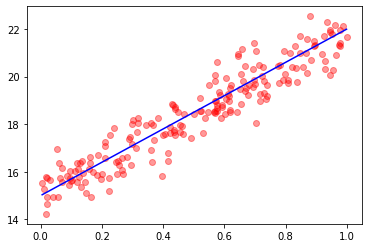

In [3]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.4)
plot_line(synt_x, synt_x * 7 + 15)
plt.show()

### Implementando Rede Neural

In [4]:
def define_params(sizes=[1, 1]):
    '''He-et-all initialization'''
    weights = []
    for i, (in_dim, out_dim) in enumerate(zip(sizes[:-1], sizes[1:])):
        weights.append({"w": np.random.randn(in_dim, out_dim) * np.sqrt(2/in_dim), 
                        "b": np.random.randn(out_dim) * np.sqrt(2/in_dim)})           
    
    return weights


def apply_fn(weights, batch_x, activations):
    output = batch_x
    for layer, act_fn in zip(weights, activations):
        output = jnp.dot(output, layer["w"]) + layer["b"]
        output = act_fn(output)
    return output

def l2_loss(weights, batch_x, real_y, activations):
    pred_y = apply_fn(weights, batch_x, activations)
    return 0.5 * np.mean((pred_y - real_y)**2)

def cross_entropy(weights, batch_x, real_y, activations):
    pred_y = apply_fn(weights, batch_x, activations)
    real_y = jnp.asarray(real_y)
    return -jnp.mean(jnp.sum(pred_y * real_y, axis=1))

### Implementando SGD

In [5]:
def train_step(weights, batch_x, batch_y, activations, loss_fn=l2_loss, lr=0.1):
    loss, grads = jax.value_and_grad(loss_fn)(weights, batch_x, batch_y, activations)
    weights = jax.tree_util.tree_multimap(lambda v, g: v - lr*g, weights, grads)
    return weights, loss


def evaluate(weights, activations, batch_x, batch_y, metrics=[], loss_fn=l2_loss):
    # run feed forward network
    pred_y = apply_fn(weights, batch_x, activations)
    # loss
    loss = loss_fn(weights, batch_x, batch_y, activations)
    # metrics
    res_metrics = []
    for m in metrics:
        res_metrics.append(m(pred_y, batch_y))
            
    return loss, res_metrics

def plot_losses(train_losses, eval_losses, step):
    if len(eval_losses) > 0:
        plt.title('Train Loss: %.4f | Test Loss: %.4f for step %d' % (train_losses[-1], eval_losses[-1], step))
        plt.plot([i for i in range(0, step, 10)], eval_losses)
    else:
        plt.title('Train Loss: %.4f for step %d' % (train_losses[-1], step))    
        
    plt.plot([i for i in range(step)], train_losses)

### Gradients

##### L2 loss with 1 layer, no activation

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - w_i * x_i + b_i)^{2}}$$

**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial w_i} $$
$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_i$$

---

$$\frac{\partial L}{\partial b_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial b_i} $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$


##### L2 loss with 2 layers, relu activation in the hidden layer

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - (w_j * x_j + b_j))^{2}}$$
$$x_j = relu(w_i * x_i + b_i)$$


**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_j $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$

$$\frac{\partial L}{\partial w_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j * x_i, se relu() > 0$$
$$\frac{\partial L}{\partial b_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j, se relu() > 0$$

### Treinando

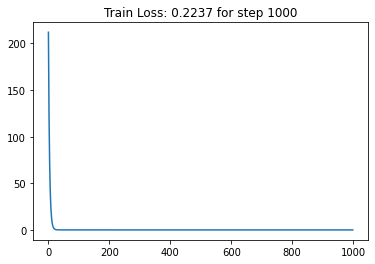

In [6]:
neural_net = define_params()
train_losses = []
eval_losses = []
for i in range(1000):
    neural_net, loss = train_step(neural_net, synt_x, synt_y, [identity])
    train_losses.append(loss)
#     if i % 10 == 0:
#         loss, metrics = evaluate(neural_net, [identity], synt_x, synt_y, metrics=[_accuracy])
#         eval_losses.append(loss)
        
plot_losses(train_losses, eval_losses, 1000)

#### Comparando com a realidade

Parâmetros aprendidos:
pesos: [[6.692199]]
bias: [15.075487]
Função que modela os dados: 7 * X + 15


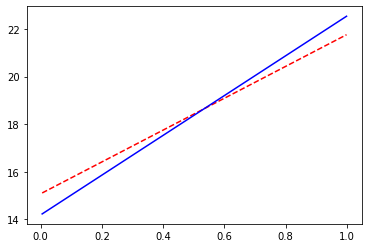

In [7]:
print('Parâmetros aprendidos:')
print('pesos:', neural_net[0]["w"])
print('bias:', neural_net[0]["b"])
print('Função que modela os dados: 7 * X + 15')
plot_line(synt_x, apply_fn(neural_net, synt_x, [identity]), '--r')
plot_line(synt_x, synt_y)
plt.show()

### Uma função um pouco mais complicada

$Y = 7 * log(x) + 1$


In [8]:
def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = jnp.reshape(7 * np.log(synt_x) + 1 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = jnp.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

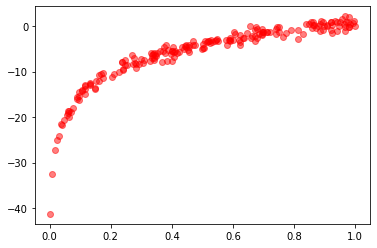

In [9]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

In [10]:
nn = define_params(sizes=[1, 10, 1])
activations=[jax.nn.sigmoid, identity]
train_losses = []
eval_losses = []

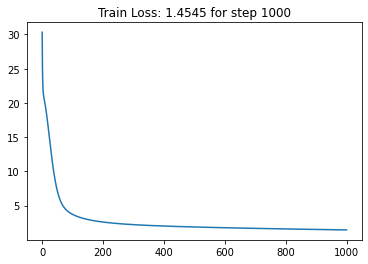

In [11]:
for i in range(1000):
    nn, loss = train_step(nn, synt_x, synt_y, activations)
    train_losses.append(loss)
#     if i % 10 == 0:
#         loss, metrics = evaluate(neural_net, [identity], synt_x, synt_y, metrics=[_accuracy])
#         eval_losses.append(loss)

plot_losses(train_losses, eval_losses, 1000)

Parâmetros aprendidos:
pesos: [DeviceArray([[-4.405657 ,  0.4860704, -7.596714 , -2.9677794, 10.011526 ,
              -2.6017227, -1.8996462, -8.952797 ,  1.0131673, -8.821257 ]],            dtype=float32), DeviceArray([[-5.419962  ],
             [-0.21313462],
             [-7.451459  ],
             [-5.0258594 ],
             [ 8.097725  ],
             [-4.566792  ],
             [-2.3503356 ],
             [-8.587139  ],
             [-1.6483995 ],
             [-8.4986925 ]], dtype=float32)]
bias: [DeviceArray([ 0.02200077, -0.5802973 , -0.1432708 ,  1.2722787 ,
             -0.08803245,  1.3667308 ,  0.03255983, -0.02162656,
              2.0635371 , -0.03442049], dtype=float32), DeviceArray([-3.8411722], dtype=float32)]
Função que modela os dados: 7 * X + 15


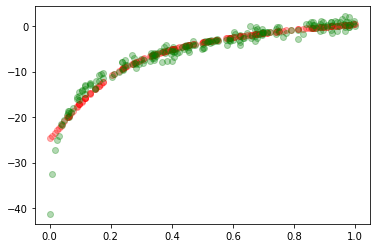

In [12]:
print('Parâmetros aprendidos:')
print('pesos:', [weight["w"] for weight in nn])
print('bias:', [weight["b"] for weight in nn])
print('Função que modela os dados: 7 * X + 15')
plt.plot(synt_x, apply_fn(nn, synt_x, activations), 'or', alpha=0.3)
plt.plot(synt_x, synt_y, 'og', alpha=0.3)
plt.show()

### E se os dados forem não lineares?

In [13]:
xor_x = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_y = jnp.array([[0], [1], [1], [0]])

In [14]:
activations=[jax.nn.relu, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)

# plot_losses()

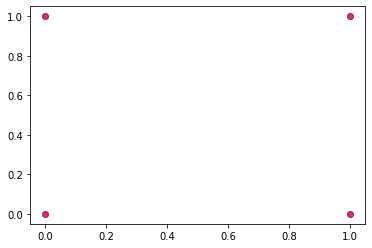

In [15]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

In [16]:
activations=[identity, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)

# plot_losses()

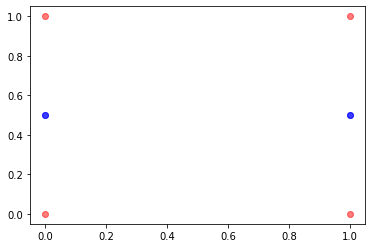

In [17]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

### Exemplo: [base dados Iris](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#iris)

Digamos que para um exemplo da base de dados queremos determinar qual a espécie dessa planta.

**Entradas**

A base de dados iris tem 4 **[atributos](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#atributos)** de uma planta que iremos usar como entrada.

**Saídas**

Neste caso a saída que nos interessa é a espécie da planta. Então digamos que a saída é um número que indica qual a espécie:

0 = Iris Setosa , 1 = Iris Versicolour, 2 = Iris Virginica

### Obtendo os dados

In [18]:
# Carregar base de dados iris
iris = load_iris()

# np.c_ concatena as features e targets do dataset
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                         columns=['x0', 'x1', 'x2', 'x3', 'target'])

In [19]:
iris_data.head()

,x0,x1,x2,x3,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [20]:
iris_data.describe()

,x0,x1,x2,x3,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


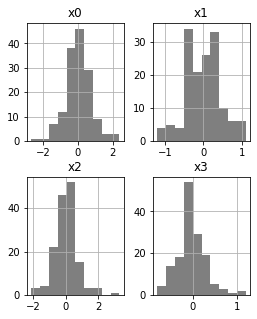

In [21]:
iris_data.drop(['target'], axis=1).diff().hist(color='k', alpha=0.5, bins=10, figsize=(4, 5))
plt.show()

In [22]:
def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)

In [23]:
x = iris.data
y = iris.target
y = _one_hot(y, 3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [24]:
def batches(x, y, batch_size=16):
    idx = np.random.permutation(len(x))
    x = x[idx]
    y = y[idx]
    
    for i in range(0, len(x)-batch_size-1, batch_size):
        batch_x = x[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        yield batch_x, batch_y

Test loss = 0.96247, accuracy 0.63158
Test loss = 0.76534, accuracy 0.71053
Test loss = 0.66534, accuracy 0.71053
Test loss = 0.62524, accuracy 0.71053
Test loss = 0.59800, accuracy 0.71053
Test loss = 0.57885, accuracy 0.71053
Test loss = 0.56278, accuracy 0.71053
Test loss = 0.54652, accuracy 0.71053
Test loss = 0.53486, accuracy 0.76316
Test loss = 0.52478, accuracy 0.76316


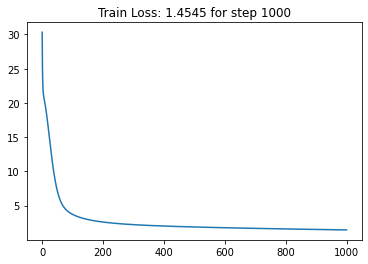

In [25]:
activations=[jax.nn.relu, jax.nn.log_softmax]
nn = define_params(sizes=[4, 10, 3])
for i in range(100):
    for batch_x, batch_y in batches(x_train, y_train):
        nn, loss = train_step(nn, batch_x, batch_y, activations, loss_fn=cross_entropy, lr=0.01)
    if i % 10 == 0:
        loss, metrics = evaluate(nn, activations, x_test, y_test, metrics=[_accuracy], loss_fn=cross_entropy)
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

plot_losses(train_losses, eval_losses, 1000)

### MNIST

In [26]:
# load mnist
mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [28]:
x = mnist[0] / np.max(mnist[0])
y = np.array([int(label) for label in mnist[1]])
y = _one_hot(y, 10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [29]:
activations=[jax.nn.relu, jax.nn.relu, jax.nn.log_softmax]
nn = define_params(sizes=[784, 512, 256, 10])
for i in range(20):
    for batch_x, batch_y in batches(x_train, y_train, 64):
        nn, loss = train_step(nn, batch_x, batch_y, activations, loss_fn=cross_entropy, lr=0.001)
    loss, metrics = evaluate(nn, activations, x_test, y_test, metrics=[_accuracy], loss_fn=cross_entropy)
    print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))
        

# t.plot_losses()

Test loss = 1.34204, accuracy 0.73646
Test loss = 0.88529, accuracy 0.81646
Test loss = 0.67878, accuracy 0.84709
Test loss = 0.57118, accuracy 0.86326
Test loss = 0.50617, accuracy 0.87320
Test loss = 0.46268, accuracy 0.88023
Test loss = 0.43193, accuracy 0.88600
Test loss = 0.40797, accuracy 0.89120
Test loss = 0.38929, accuracy 0.89606
Test loss = 0.37444, accuracy 0.89977
Test loss = 0.36173, accuracy 0.90217
Test loss = 0.35139, accuracy 0.90497
Test loss = 0.34184, accuracy 0.90789
Test loss = 0.33357, accuracy 0.90869
Test loss = 0.32648, accuracy 0.91091
Test loss = 0.31970, accuracy 0.91257
Test loss = 0.31361, accuracy 0.91423
Test loss = 0.30800, accuracy 0.91611
Test loss = 0.30299, accuracy 0.91669
Test loss = 0.29812, accuracy 0.91777
